# 範例2. 使用Shap套件，觀察圖像那些位置對辨識最有幫助

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [1]:
import tensorflow as tf

# 目前 tensorflow 2.x 版執行 shap 有 bug
tf.compat.v1.disable_v2_behavior()

# 載入 MNIST 手寫阿拉伯數字資料
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


## 步驟2：定義 CNN 模型

In [2]:
# 建立模型
from tensorflow.keras import layers
import numpy as np

# 增加一維在最後面
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

# CNN 模型
input_shape=(28, 28, 1)
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 步驟3：模型訓練

In [3]:
# 模型訓練
history = model.fit(x_train_norm, y_train, epochs=5, validation_split=0.2)

# 評分(Score Model)
score=model.evaluate(x_test_norm, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
47936/48000 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9265

C:\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 9s 186us/sample - loss: 0.2366 - acc: 0.9266 - val_loss: 0.0713 - val_acc: 0.9791
Epoch 2/5
48000/48000 [==============================] - 8s 161us/sample - loss: 0.0867 - acc: 0.9736 - val_loss: 0.0511 - val_acc: 0.9845
Epoch 3/5
48000/48000 [==============================] - 8s 161us/sample - loss: 0.0667 - acc: 0.9793 - val_loss: 0.0492 - val_acc: 0.9857
Epoch 4/5
48000/48000 [==============================] - 8s 162us/sample - loss: 0.0574 - acc: 0.9821 - val_loss: 0.0399 - val_acc: 0.9876
Epoch 5/5
48000/48000 [==============================] - 8s 161us/sample - loss: 0.0507 - acc: 0.9839 - val_loss: 0.0400 - val_acc: 0.9887
loss: 0.0366
acc: 0.9876


## 步驟4：Shap values 計算

In [24]:
import shap
import numpy as np

# 計算 Shap value 的 base
# 目前 tensorflow 2.x 版執行 shap 有 bug
# background = x_train[np.random.choice(x_train_norm.shape[0], 100, replace=False)]
# e = shap.DeepExplainer(model, background)         # shap values 不明顯
e = shap.DeepExplainer(model, x_train_norm[:100])

# 測試第 1 筆
shap_values = e.shap_values(x_test_norm[:1])
shap_values

[array([[[[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],
 
         [[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [

In [29]:
np.array(shap_values).shape

(10, 1, 28, 28, 1)

## 步驟5：繪製5筆測試資料的特徵歸因

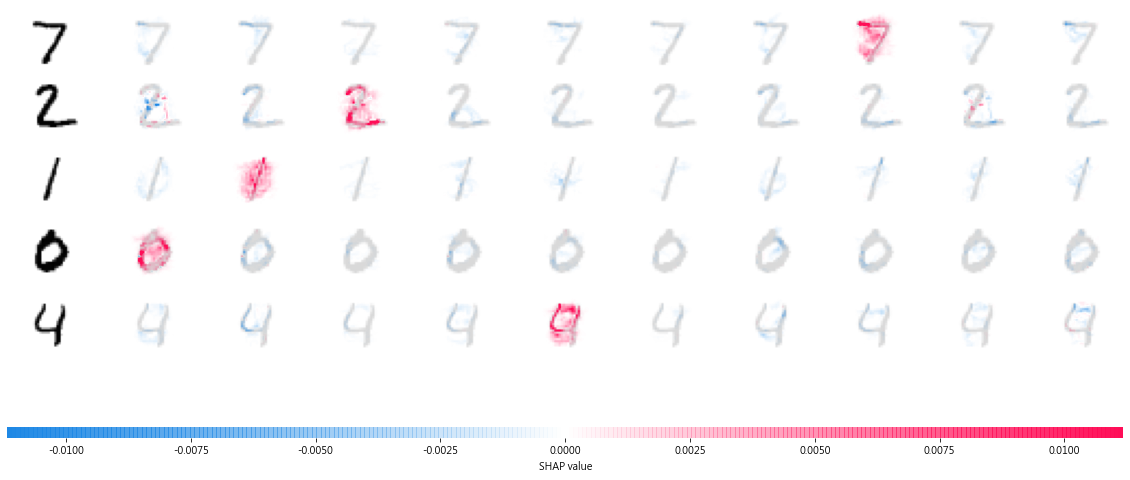

In [20]:
# 繪製特徵的歸因(feature attribution)
shap.image_plot(shap_values, -x_test_norm[:5])